In [ ]:
import os
import numpy as np
import torch
import importlib
import consts
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
from scipy.spatial.distance import cdist
from scipy.stats import ortho_group
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pyLDAvis
from toolbox.alias_multinomial import AliasMultinomial

# 重新載入 consts 以確保變數最新
importlib.reload(consts)
torch.manual_seed(consts.SEED)
np.random.seed(consts.SEED)

In [2]:
# 確保輸出目錄存在
output_dir = "newsgroup_test"
os.makedirs(output_dir, exist_ok=True)

# ✅ 下載 20 Newsgroups 資料集並轉換為 BoW
categories = None
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=('headers', 'footers', 'quotes'))

vectorizer = CountVectorizer(max_features=5000, stop_words='english', token_pattern=r'(?u)\b[A-Za-z]{3,}\b')# 只允許至少 3 個英文字母的單詞
X_train = vectorizer.fit_transform(newsgroups_train.data).toarray()
X_test = vectorizer.transform(newsgroups_test.data).toarray()
vocab = vectorizer.get_feature_names_out()
y_train = np.array(newsgroups_train.target)
y_test = np.array(newsgroups_test.target)

In [3]:
# ✅ 產生 word_counts 與 doc_lens
word_counts = np.sum(X_train, axis=0)
doc_lens_train = np.sum(X_train, axis=1)
doc_lens_test = np.sum(X_test, axis=1)

In [4]:
# ✅ 轉換為 PyTorch Tensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device)

In [5]:
# ✅ 產生 doc_windows（上下文窗口）
def get_windows(bow_matrix, window_size=5):
    n_docs, vocab_size = bow_matrix.shape
    windows = []
    for doc_idx in range(n_docs):
        indices = np.nonzero(bow_matrix[doc_idx])[0]
        if len(indices) >= window_size:
            for i in range(len(indices) - window_size + 1):
                window = indices[i:i+window_size]
                windows.append([doc_idx] + list(window))
    return np.array(windows)

doc_windows = get_windows(X_train)

In [6]:
print("前 20 個詞:", doc_windows[:20])  # 確認前 20 個詞是否合理

前 20 個詞: [[   0   58  495  610  642 1128]
 [   0  495  610  642 1128 1356]
 [   0  610  642 1128 1356 1357]
 [   0  642 1128 1356 1357 1400]
 [   0 1128 1356 1357 1400 1474]
 [   0 1356 1357 1400 1474 2067]
 [   0 1357 1400 1474 2067 2226]
 [   0 1400 1474 2067 2226 2444]
 [   0 1474 2067 2226 2444 2476]
 [   0 2067 2226 2444 2476 2613]
 [   0 2226 2444 2476 2613 2614]
 [   0 2444 2476 2613 2614 2655]
 [   0 2476 2613 2614 2655 2846]
 [   0 2613 2614 2655 2846 3470]
 [   0 2614 2655 2846 3470 3636]
 [   0 2655 2846 3470 3636 3787]
 [   0 2846 3470 3636 3787 3923]
 [   0 3470 3636 3787 3923 4019]
 [   0 3636 3787 3923 4019 4154]
 [   0 3787 3923 4019 4154 4221]]


In [7]:
# ✅ 自訂 PyTorch Dataset
class DocWindowsDataset(Dataset):
    def __init__(self, windows):
        self.data = windows

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.long)

In [ ]:
# ✅ 概念挖掘模型
class GuidedDiverseConceptMiner(nn.Module):
    def __init__(self, vocab, vocab_size, nconcepts=10, embed_dim=50, nnegs=15, bow_train=None, y_train=None, doc_windows=None, word_counts=None):
        super(GuidedDiverseConceptMiner, self).__init__()
        self.vocab=vocab
        self.nconcepts = nconcepts
        self.nnegs = nnegs
        self.embedding_i = nn.Embedding(vocab_size, embed_dim)
        self.embedding_t = nn.Parameter(torch.FloatTensor(ortho_group.rvs(embed_dim)[0:nconcepts]))
        self.doc_concept_weights = nn.Embedding(bow_train.shape[0], nconcepts)
        self.docweights = torch.ones(bow_train.shape[0], dtype=torch.float32, device=device)
        self.train_dataset = DocWindowsDataset(doc_windows)
        self.dropout = nn.Dropout(0.5)
        self.linear = nn.Linear(nconcepts, 1)

        if torch.cuda.is_available():
            self.device = "cuda"
        else:
            self.device = "cpu"
        
        device = torch.device(self.device)
        self.bow_train = torch.tensor(bow_train, dtype=torch.float32, requires_grad=False, device=device)

        #negative sampling的權重
        wf = np.power(word_counts, 0.75)
        self.word_counts=word_counts
        wf = wf / np.sum(wf)
        self.weights = torch.tensor(wf, dtype=torch.float32, requires_grad=False, device=device)
        
        self.dropout1 = nn.Dropout(consts.PIVOTS_DROPOUT)
        self.dropout2 = nn.Dropout(consts.DOC_VECS_DROPOUT)
        self.multinomial = AliasMultinomial(wf, self.device)

    def forward(self, doc, target, contexts):
        batch_size, window_size = contexts.size(0)
        #用文件長度重新調整loss權重
        w = autograd.Variable(self.docweights[doc.data]).to(self.device)
        w /= w.sum()
        w *= w.size(0)

        doc_concept_probs = F.softmax(self.doc_concept_weights(doc), dim=1) #計算每個文件與不同概念的關聯程度
        concept_embeddings = self.embedding_t.expand(batch_size, -1, -1) #把embedding_t(概念向量)展開，讓它的形狀從(nnconcepts, embed_dim)，變成(batch_size, nnconcepts, embed_dim)，為了下一步torch.bmm的計算
        doc_vector = torch.bmm(doc_concept_probs.unsqueeze(1), concept_embeddings).squeeze(1) #doc_vector，代表每個文件的最終向量表示，用來計算概念權重，影響預測結果。(batch_size, 1, nnconcepts) x (batch_size, nnconcepts, embed_dim) = (batch_size, 1, embed_dim)
        
        #sample negative word indices for negative sampling loss; approximation by sampling from the whole vocab
        nwords = self.multinomial.draw(batch_size * window_size * self.nnegs)
        nwords = autograd.Variable(nwords).view(batch_size, window_size * self.nnegs)

        #計算word vectors
        ivectors = self.dropout1(self.embedding_i(target)) #目標詞向量
        ovectors = self.embedding_i(contexts) #上下文詞向量
        nvectors = self.embedding_i(nwords).neg() #負樣本詞向量

        context_vectors = doc_vector + ivectors
        context_vectors = context_vectors.unsqueeze(2)

        #計算negative sampling loss
        oloss = torch.bmm(ovectors, context_vectors).squeeze(dim=2).sigmoid().clamp(min=1e-9).log().sum(1)
        nloss = torch.bmm(nvectors, context_vectors).squeeze(dim=2).sigmoid().clamp(min=1e-9).log().sum(1)
        negative_sampling_loss = (oloss + nloss).neg()
        negative_sampling_loss *= w
        negative_sampling_loss = negative_sampling_loss.mean()
        
        pred_weight = self.linear(doc_concept_probs)
        return pred_weight

    def fit(self, lr=0.01, nepochs=10, batch_size=100):
        train_dataloader = DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True)
        optimizer = optim.Adam(self.parameters(), lr=lr)
        for epoch in range(nepochs):
            for batch in train_dataloader:
                doc, target, contexts = batch[:, 0], batch[:, 1], batch[:, 2:]
                pred = self(doc, target, contexts)
                loss = F.mse_loss(pred, target.float().unsqueeze(1))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            print(f"Epoch {epoch + 1}/{nepochs}, Loss: {loss.item():.4f}")

    def visualize(self, top_k=10, concept_dist='dot'):
        """
        可視化每個概念的關鍵詞詞雲。

        Parameters:
        - top_k: 每個概念取前 K 個相關詞
        - concept_dist: 計算概念與詞語之間的距離 ('dot', 'cosine', 'euclidean' 等)
        """
        wordcloud = WordCloud(width=800, height=400, background_color='white')

        # 取得每個概念的前 K 個關鍵詞
        concept_words_list = self.get_concept_words(top_k=top_k, concept_dist=concept_dist)

        for i, concept_words in enumerate(concept_words_list):
            # 為詞雲創建詞頻字典（每個詞的頻率設為固定值，確保詞雲可視化）
            concept_word_freqs = {word: 1.0 for word in concept_words}

            # 生成詞雲
            wc = wordcloud.generate_from_frequencies(concept_word_freqs)

            # 顯示詞雲
            plt.figure(figsize=(8, 4))
            plt.imshow(wc, interpolation='bilinear')
            plt.axis("off")
            plt.title(f"Concept {i+1}")
            plt.show()
        
    def get_concept_words(self, top_k=10, concept_dist='dot'):
        """
        獲取每個概念最相關的詞彙。
        
        Parameters:
        - top_k: 取前 K 個相關的詞
        - concept_dist: 計算概念與詞語之間距離的方法 (可選: 'dot', 'cosine', 'euclidean' 等)
        """
        concept_embed = self.embedding_t.data.cpu().numpy()
        word_embed = self.embedding_i.weight.data.cpu().numpy()

        if concept_dist == 'dot':
            dist = -np.matmul(concept_embed, np.transpose(word_embed, (1, 0)))
        else:
            dist = cdist(concept_embed, word_embed, metric=concept_dist)

        nearest_word_idxs = np.argsort(dist, axis=1)[:, :top_k]  # 找到最相關的 top_k 個詞

        concepts = []
        for j in range(self.nconcepts):
            nearest_words = [self.vocab[i] for i in nearest_word_idxs[j, :]]
            concepts.append(nearest_words)

        return concepts

In [9]:
# ✅ 訓練模型
gdcm = GuidedDiverseConceptMiner(
    vocab=vocab,
    vocab_size=len(vocab),
    bow_train=X_train_tensor.cpu().numpy(),
    y_train=y_train_tensor.cpu().numpy(),
    doc_windows=doc_windows
)

In [10]:
# 查看詞彙表的前 50 個單詞
print("Vocabulary sample:", vocab[:50])

# 檢查概念關鍵詞的選擇
concepts = gdcm.get_concept_words(top_k=10, concept_dist="cosine")
for i, concept_words in enumerate(concepts):
    print(f'Concept {i+1}: {concept_words}')

Vocabulary sample: ['aaa' 'abc' 'abiding' 'ability' 'able' 'abort' 'abortion' 'abs' 'absence'
 'absolute' 'absolutely' 'abstract' 'abuse' 'abuses' 'academic'
 'acceleration' 'accelerator' 'accept' 'acceptable' 'acceptance'
 'accepted' 'accepting' 'access' 'accident' 'accidental' 'accidents'
 'accomplished' 'according' 'account' 'accounts' 'accuracy' 'accurate'
 'accused' 'achieve' 'achieved' 'acid' 'acknowledge' 'aclu' 'acquire'
 'acquired' 'act' 'acting' 'action' 'actions' 'active' 'actively'
 'activities' 'activity' 'acts' 'actual']
Concept 1: ['consider', 'text', 'ads', 'checks', 'recovery', 'idle', 'doesn', 'jumped', 'boy', 'buck']
Concept 2: ['courtesy', 'gizw', 'graphical', 'qualified', 'class', 'compressed', 'discovered', 'systems', 'address', 'widespread']
Concept 3: ['foreign', 'inside', 'selling', 'seat', 'rumor', 'pixel', 'low', 'perry', 'parameters', 'member']
Concept 4: ['refers', 'arena', 'badly', 'larger', 'carry', 'reagan', 'fled', 'son', 'clock', 'michael']
Concept 5: 

In [11]:
gdcm.fit(nepochs=5, batch_size=100)

Epoch 1/5, Loss: 6528760.0000
Epoch 2/5, Loss: 7994074.5000
Epoch 3/5, Loss: 7089277.5000
Epoch 4/5, Loss: 8294174.5000
Epoch 5/5, Loss: 5783658.0000


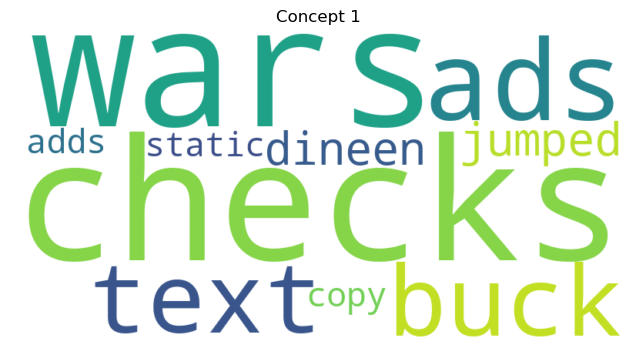

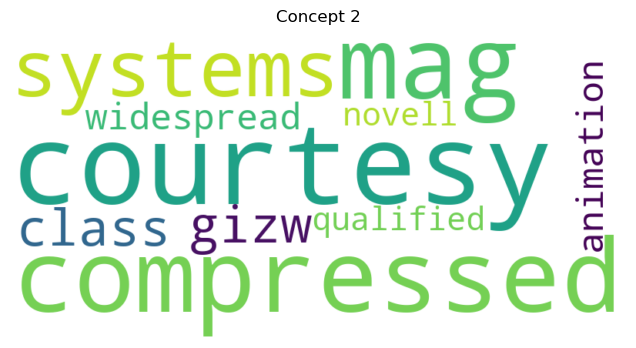

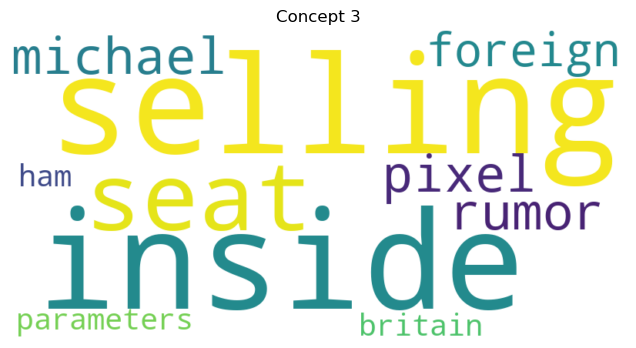

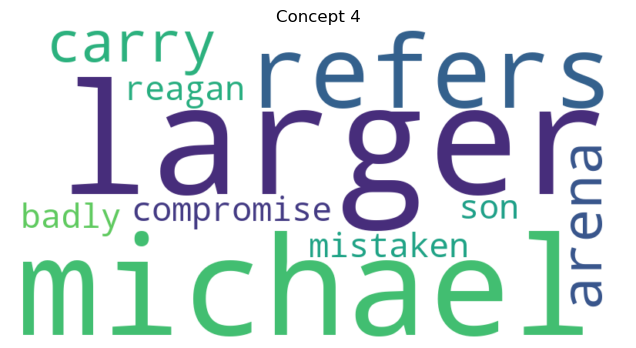

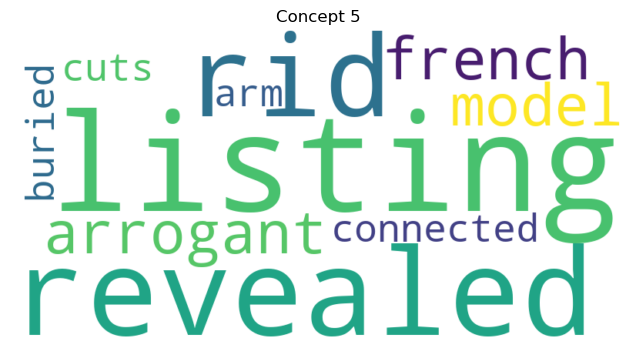

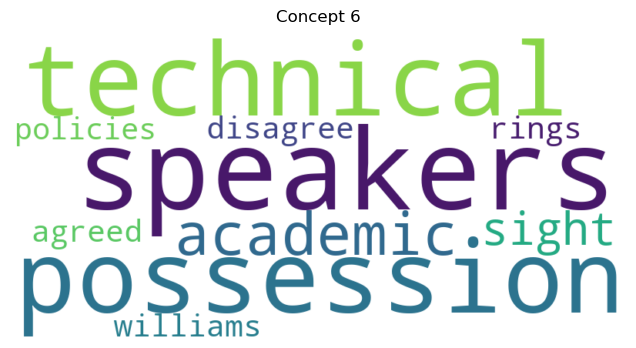

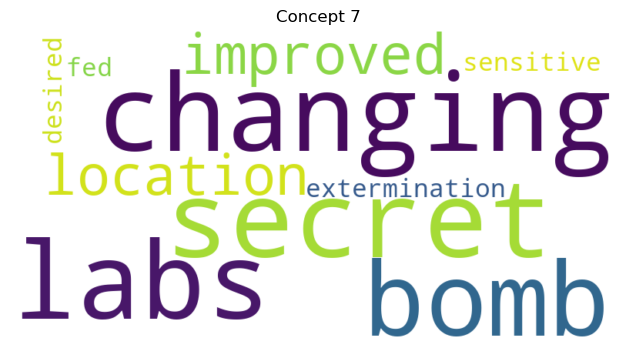

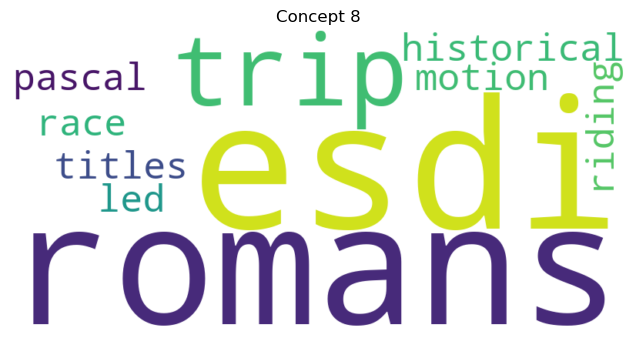

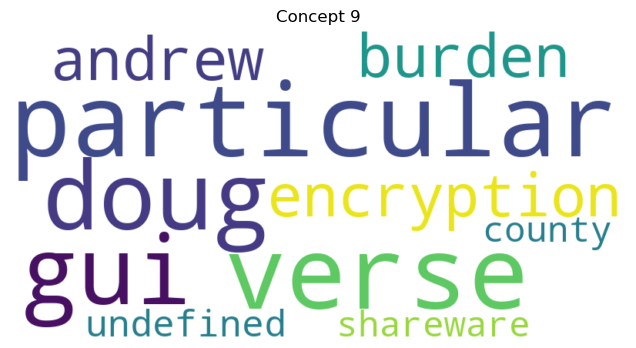

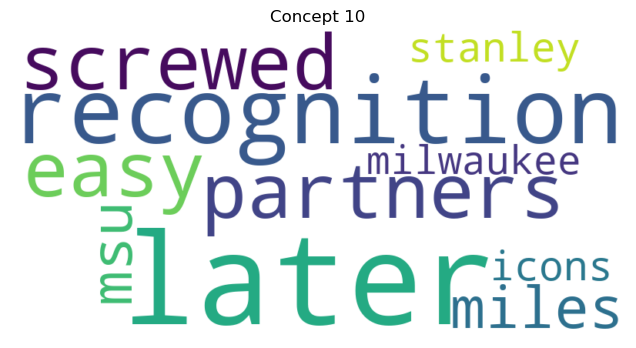

In [12]:
# ✅ 產生概念視覺化
gdcm.visualize()